#### Imports


In [1]:
import pandas as pd
import numpy as np
import wrangle

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exercises

#### 1. Load the tips dataset.



In [4]:
from pydataset import data
tips = data('tips')

In [5]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


#### a. Create a column named price_per_person. This should be the total bill divided by the party size.



In [6]:
tips['price_per_person'] = round(tips.total_bill / tips['size'], 2)

In [7]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00
4,23.68,3.31,Male,No,Sun,Dinner,2,11.84
5,24.59,3.61,Female,No,Sun,Dinner,4,6.15


#### b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

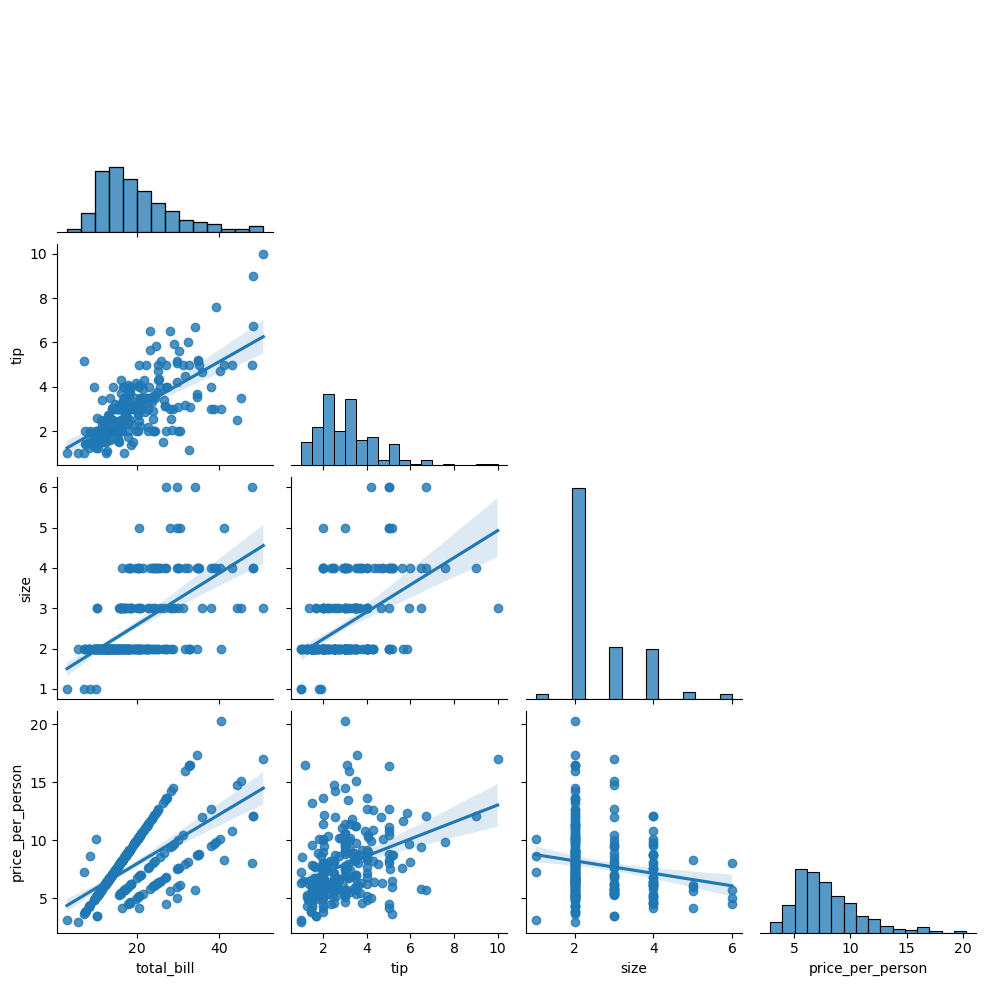

In [8]:
sns.pairplot(tips, kind='reg', corner=True)
plt.show()

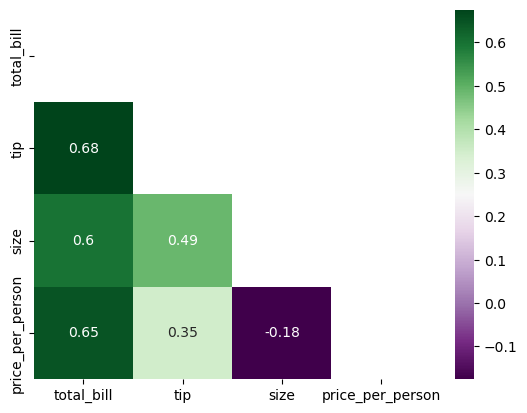

In [9]:
sns.heatmap(tips.corr(), cmap='PRGn', annot=True, mask=np.triu(tips.corr()))
plt.show()

***A. total_bill size***

In [15]:
dummy_tips = pd.get_dummies(tips[['sex', 'smoker', 'day', 'time']], drop_first=True)

In [16]:
dummy_tips.head()

,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
1,0,0,0,1,0,0
2,1,0,0,1,0,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0
5,0,0,0,1,0,0


In [17]:
tips = pd.concat([tips, dummy_tips], axis=1)

In [18]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49,0,0,0,1,0,0
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45,1,0,0,1,0,0
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00,1,0,0,1,0,0
4,23.68,3.31,Male,No,Sun,Dinner,2,11.84,1,0,0,1,0,0
5,24.59,3.61,Female,No,Sun,Dinner,4,6.15,0,0,0,1,0,0


In [19]:
train, validate, test = wrangle.split_function(tips)

In [20]:
print(f'tips:', tips.shape)
print(f'train:', train.shape)
print(f'validate:', validate.shape)
print(f'test:', test.shape)

tips: (244, 14)
train: (146, 14)
validate: (49, 14)
test: (49, 14)


In [21]:
train.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
225,13.42,1.58,Male,Yes,Fri,Lunch,2,6.71,1,1,0,0,0,1
182,23.33,5.65,Male,Yes,Sun,Dinner,2,11.66,1,1,0,1,0,0
103,44.30,2.50,Female,Yes,Sat,Dinner,3,14.77,0,1,1,0,0,0
165,17.51,3.00,Female,Yes,Sun,Dinner,2,8.76,0,1,0,1,0,0
74,25.28,5.00,Female,Yes,Sat,Dinner,2,12.64,0,1,1,0,0,0


In [22]:
def scale_data(train,
              validate,
              test,
              to_scale):
    # make copies for scaling
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # Make the thing
    scaler = MinMaxScaler()
    
    #fit the thing
    scaler.fit(train[to_scale])
    
    #use the thing
    train_scaled[to_scale] = scaler.transform(train[to_scale])
    validate_scaled[to_scale] = scaler.transform(validate[to_scale])
    test_scaled[to_scale] = scaler.transform(test[to_scale])
    
    return train_scaled, validate_scaled, test_scaled

In [23]:
to_scale = ['total_bill', 'size', 'price_per_person', 'sex_Male', 'smoker_Yes',
            'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']

In [24]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, to_scale)

In [25]:
X_train, y_train = train_scaled[['total_bill', 'size', 'price_per_person', 'sex_Male', 'smoker_Yes',
                          'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']], train.tip
X_validate, y_validate = validate_scaled[['total_bill', 'size', 'price_per_person', 'sex_Male', 'smoker_Yes',
                          'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']], validate.tip
X_test, y_test = test_scaled[['total_bill', 'size', 'price_per_person', 'sex_Male', 'smoker_Yes',
                          'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']], test.tip

In [26]:
X_train.head()

,total_bill,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
225,0.228679,0.2,0.211628,1.0,1.0,0.0,0.0,0.0,1.0
182,0.447636,0.2,0.499419,1.0,1.0,0.0,1.0,0.0,0.0
103,0.910959,0.4,0.680233,0.0,1.0,1.0,0.0,0.0,0.0
165,0.319046,0.2,0.330814,0.0,1.0,0.0,1.0,0.0,0.0
74,0.490720,0.2,0.556395,0.0,1.0,1.0,0.0,0.0,0.0


In [27]:
y_train[:5]

225    1.58
182    5.65
103    2.50
165    3.00
74     5.00
Name: tip, dtype: float64

#### c. Use select k best to select the top 2 features for predicting tip amount. What are they?

In [28]:
# make the thing
kbest = SelectKBest(f_regression, k=2)

# fit the thing
kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x13a166430>)

In [29]:
kbest.scores_

array([1.11115028e+02, 5.76071336e+01, 1.38356417e+01, 5.96049171e-01,
       8.45071808e-02, 2.50128222e-02, 3.28560161e+00, 9.78681779e-01,
       2.18955757e+00])

In [30]:
kbest.pvalues_

array([1.30561953e-19, 3.66901154e-12, 2.85187703e-04, 4.41354619e-01,
       7.71698118e-01, 8.74556685e-01, 7.19730319e-02, 3.24183852e-01,
       1.41133637e-01])

In [31]:
kbest.feature_names_in_

array(['total_bill', 'size', 'price_per_person', 'sex_Male', 'smoker_Yes',
       'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch'], dtype=object)

In [32]:
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                index = X_train.columns)

In [33]:
kbest_results.sort_values(by=['f'], ascending=False)

,p,f
total_bill,1.305620e-19,111.115028
size,3.669012e-12,57.607134
price_per_person,2.851877e-04,13.835642
day_Sun,7.197303e-02,3.285602
time_Lunch,1.411336e-01,2.189558
day_Thur,3.241839e-01,0.978682
sex_Male,4.413546e-01,0.596049
smoker_Yes,7.716981e-01,0.084507
day_Sat,8.745567e-01,0.025013


In [34]:
kbest.get_support()

array([ True,  True, False, False, False, False, False, False, False])

In [35]:
X_train.columns[kbest.get_support()]

Index(['total_bill', 'size'], dtype='object')

In [36]:
kbest.transform(X_train)[:5]

array([[0.22867875, 0.2       ],
       [0.44763588, 0.2       ],
       [0.9109589 , 0.4       ],
       [0.31904551, 0.2       ],
       [0.49072028, 0.2       ]])

In [37]:
X_train_KBtransformed = pd.DataFrame(
                        kbest.transform(X_train),
                        columns = X_train.columns[kbest.get_support()],
                        index = X_train.index)

In [38]:
X_train_KBtransformed.head()

,total_bill,size
225,0.228679,0.2
182,0.447636,0.2
103,0.910959,0.4
165,0.319046,0.2
74,0.490720,0.2


#### d. Use recursive feature elimination to select the top 2 features for tip amount. What are they?

In [39]:
model = LinearRegression()

In [40]:
# Make the thing
rfe = RFE(model, n_features_to_select=2)

# Fit the thing
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [41]:
# feature ranking
rfe.ranking_

array([1, 6, 1, 4, 7, 2, 8, 3, 5])

In [42]:
pd.DataFrame(
{'rfe_ranking': rfe.ranking_},
index = X_train.columns)

,rfe_ranking
total_bill,1
size,6
price_per_person,1
sex_Male,4
smoker_Yes,7
day_Sat,2
day_Sun,8
day_Thur,3
time_Lunch,5


In [61]:
rfe.get_support()

array([ True, False,  True, False, False, False, False, False, False])

In [62]:
X_train_RFEtransformed = pd.DataFrame(
    rfe.transform(X_train),
    index = X_train.index,
    columns = X_train.columns[rfe.support_])

In [63]:
X_train_RFEtransformed.head()

,total_bill,price_per_person
225,0.228679,0.211628
182,0.447636,0.499419
103,0.910959,0.680233
165,0.319046,0.330814
74,0.490720,0.556395


#### e. Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

#### 2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [71]:
def select_kbest(X_train, y_train, a):
    '''
    Scale data for X_train, y_train before using this function
    Inputs:
    X_train, y_train, a=number of features to select (k)
    Outputs:
    kbest_results, X_train_KBtransformed 
    '''
    
    # make the thing
    kbest = SelectKBest(f_regression, k=a)
    # fit the thing
    kbest.fit(X_train, y_train)
    
    kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                index = X_train.columns)
    
    
    X_train_KBtransformed = pd.DataFrame(
                        kbest.transform(X_train),
                        columns = X_train.columns[kbest.get_support()],
                        index = X_train.index)
    
    return kbest_results, X_train_KBtransformed

In [67]:
kbest_results2, X_train_KBtransformed2 = select_kbest(X_train, y_train, 2)

In [68]:
kbest_results2

,p,f
total_bill,1.305620e-19,111.115028
size,3.669012e-12,57.607134
price_per_person,2.851877e-04,13.835642
sex_Male,4.413546e-01,0.596049
smoker_Yes,7.716981e-01,0.084507
day_Sat,8.745567e-01,0.025013
day_Sun,7.197303e-02,3.285602
day_Thur,3.241839e-01,0.978682
time_Lunch,1.411336e-01,2.189558


In [70]:
X_train_KBtransformed2.head()

,total_bill,size
225,0.228679,0.2
182,0.447636,0.2
103,0.910959,0.4
165,0.319046,0.2
74,0.490720,0.2


#### 3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [72]:
def rfe(X_train, y_train, a):
    '''
    Scale data for X_train, y_train before using this function
    Inputs:
    X_train, y_train, a = n_features_to_select
    Outputs:
    rfe_results, X_train_RFEtransformed
    '''
    
    model = LinearRegression()
    # Make the thing
    rfe = RFE(model, n_features_to_select = a)
    # Fit the thing
    rfe.fit(X_train, y_train)
    
    rfe_results = pd.DataFrame(
                    {'rfe_ranking': rfe.ranking_},
                    index = X_train.columns)
    
    X_train_RFEtransformed = pd.DataFrame(
                                rfe.transform(X_train),
                                index = X_train.index,
                                columns = X_train.columns[rfe.support_])
    
    return rfe_results, X_train_RFEtransformed

In [73]:
rfe_results2, X_train_RFEtransformed2 = rfe(X_train, y_train, 2)

In [74]:
rfe_results2

,rfe_ranking
total_bill,1
size,6
price_per_person,1
sex_Male,4
smoker_Yes,7
day_Sat,2
day_Sun,8
day_Thur,3
time_Lunch,5


In [76]:
X_train_RFEtransformed2.head()

,total_bill,price_per_person
225,0.228679,0.211628
182,0.447636,0.499419
103,0.910959,0.680233
165,0.319046,0.330814
74,0.490720,0.556395


#### 4. Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [77]:
from pydataset import data
swiss = data('swiss')

In [78]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [79]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [84]:
train2, validate2, test2 = wrangle.split_function(swiss)

In [85]:
print(f'swiss:', swiss.shape)
print(f'train2:', train2.shape)
print(f'validate2:', validate2.shape)
print(f'test2:', test2.shape)

swiss: (47, 6)
train2: (27, 6)
validate2: (10, 6)
test2: (10, 6)


In [90]:
to_scale2 = ['Agriculture', 'Examination', 'Education', 'Catholic',
            'Infant.Mortality']

In [91]:
train_scaled2, validate_scaled2, test_scaled2 = scale_data(train2, validate2, test2, to_scale)

In [92]:
X_train2, y_train2 = train_scaled2[['Agriculture', 'Examination', 'Education', 'Catholic',
                                    'Infant.Mortality']], train2.Fertility
X_validate2, y_validate2 = validate_scaled2[['Agriculture', 'Examination', 'Education', 'Catholic',
                                    'Infant.Mortality']], validate2.Fertility
X_test2, y_test2 = test_scaled2[['Agriculture', 'Examination', 'Education', 'Catholic',
                                    'Infant.Mortality']], test2.Fertility

In [109]:
kbest_results2, X_train_KBtransformed2 = select_kbest(X_train2, y_train2, 3)

In [110]:
kbest_results2

,p,f
Agriculture,0.361133,0.865382
Examination,0.014640,6.879380
Education,0.021182,6.048757
Catholic,0.002148,11.707395
Infant.Mortality,0.017704,6.448157


In [111]:
X_train_KBtransformed2.head()

,Examination,Catholic,Infant.Mortality
Rive Droite,0.40625,0.492786,0.316327
Aubonne,0.34375,0.000000,0.408163
Rolle,0.40625,0.055766,0.122449
Lavaux,0.50000,0.005832,0.500000
Nyone,0.59375,0.131689,0.163265


In [112]:
rfe_results3, X_train_RFEtransformed3 = rfe(X_train2, y_train2, 3)

In [113]:
rfe_results3

,rfe_ranking
Agriculture,2
Examination,1
Education,1
Catholic,3
Infant.Mortality,1


In [114]:
X_train_RFEtransformed3.head()

,Examination,Education,Infant.Mortality
Rive Droite,0.40625,0.903226,0.316327
Aubonne,0.34375,0.193548,0.408163
Rolle,0.40625,0.290323,0.122449
Lavaux,0.50000,0.258065,0.500000
Nyone,0.59375,0.354839,0.163265
